In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from numpy.random import normal, standard_t, chisquare

import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error

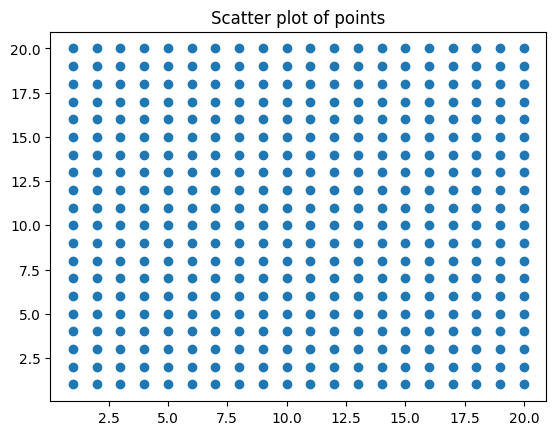

In [ ]:
# Generate a regular grid of points in a 2D space
x = np.arange(1, 21)
y = np.arange(1, 21)
S = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

# Plot the points
plt.scatter(S[:, 0], S[:, 1])
plt.title('Scatter plot of points')
plt.show()

# Calculate pairwise distances between points
d = squareform(pdist(S))

# Create a spatial weight matrix (W) based on a distance threshold of 1.25
W = (d < 1.25).astype(int)

# Set diagonal elements to 0 to avoid self-connectivity
np.fill_diagonal(W, 0)

In [ ]:
def simulate_data_1(rho, error):
    # Define the parameters
    n = 400  # Number of observations
    k = 4    # Number of independent variables

    # Simulate independent variables (x1, x2, x3, x4)
    X = np.random.normal(0, 1, size = (n, k))

    # Simulate the error term (epsilon)
    if error == 'normal':
        epsilon = np.random.normal(0, np.sqrt(0.25), n)
    elif error == 't':
        epsilon = standard_t(3, size=n)
    elif error == 'chi2':
        epsilon = chisquare(3, size=n)

    # Calculate the dependent variable (Y)
    Y = np.dot(np.linalg.inv(np.eye(n) - rho * W), (4 * X[:, 0] + 3.5 * X[:, 1] + 3 * X[:, 2] + 2.5 * X[:, 3] + epsilon))

    # View the simulated data
    return pd.DataFrame({'Y': Y, 'X1': X[:, 0], 'X2': X[:, 1], 'X3': X[:, 2], 'X4': X[:, 3]})

In [ ]:
# Set the random seed for reproducibility
# np.random.seed(42)

def choose_model(mod):
  if mod == "NSARNN":
    X['Spatial Column'] = np.dot(W, y)

  rep = 25  # Number of repetitions
  train_mse_list = []
  test_mse_list = []

  for i in range(rep):
      # Train Test Split
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0025)
      # random_row = random.randint(1, 400)
      # X_train, X_test = X[X.index != random_row], X[X.index == random_row]
      # y_train, y_test = y[y.index != random_row], y[y.index == random_row]

      # Define the neural network model
      model = Sequential([
          Dense(100, input_shape = (X_train.shape[1],), activation = 'relu'),
          Dense(1, activation = 'linear')
      ])

      # Compile the model
      model.compile(
          loss = 'mean_squared_error',
          optimizer = tf.keras.optimizers.Adam(),
          metrics = ['mean_squared_error']
      )

      # Train the model
      history = model.fit(
          x = X_train,
          y = y_train,
          epochs = 100,
          batch_size = 32,
          #validation_split = 0.2,
          verbose = 0  # Set verbose to 1 if you want to see training progress
      )

      # Make predictions on training and test data
      train_pred = model.predict(X_train).flatten()
      test_pred = model.predict(X_test).flatten()

      # Calculate Train MSE and Test MSE
      train_mse = mean_squared_error(y_train, train_pred)
      test_mse = mean_squared_error(y_test, test_pred)
      # train_mse = np.mean((y_train - train_pred)**2)
      # test_mse = np.mean((y_test - test_pred)**2)

      train_mse_list.append(train_mse)
      test_mse_list.append(test_mse)

      # print(f"Iteration {i+1}/{rep}: Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}")
      # print(i)

  # Calculate the mean error across all iterations
  mean_train_mse = np.mean(train_mse_list)
  mean_test_mse = np.mean(test_mse_list)

  # print(f"Train MSE: {mean_train_mse:.4f}")
  # print(f"Test MSE: {mean_train_mse:.4f}")

  return mean_train_mse.round(3), mean_test_mse.round(3)

In [ ]:
rho_list = [0.2, 0.4, 0.6]
epsilon_list = ['normal', 't', 'chi2']
model_name = ['ANN', 'NSARNN']

In [ ]:
ANN_Train_MSE_list = []
ANN_Test_MSE_list = []
NSARNN_Train_MSE_list = []
NSARNN_Test_MSE_list = []

for rho in rho_list:

  for epsilon in epsilon_list:
    data = simulate_data_1(rho, epsilon)
    X = data.drop(columns = 'Y')
    y = data.Y

    for mod in model_name:
      a, b = choose_model(mod)
      if mod == 'ANN':
        ANN_Train_MSE_list.append(a)
        ANN_Test_MSE_list.append(b)
      else:
        NSARNN_Train_MSE_list.append(a)
        NSARNN_Test_MSE_list.append(b)

1/1 [==============================] - 0s 22ms/step


KeyboardInterrupt: ignored

In [ ]:
Table_1 = pd.DataFrame({'ANN Train': ANN_Train_MSE_list,
                        'NSARNN Train': NSARNN_Train_MSE_list,
                        'ANN Test': ANN_Test_MSE_list,
                        'NSARNN Test': NSARNN_Test_MSE_list})

In [ ]:
Table_1

,ANN Train,NSARNN Train,ANN Test,NSARNN Test
0,25.301,0.259,30.655,0.362
1,24.300,2.303,35.738,1.029
2,43.422,5.203,45.002,9.317
3,32869.860,3.802,32503.525,2.467
4,13007.525,5.033,14095.363,3.202
5,4556.652,6.475,6437.905,6.266
6,1558.910,0.274,1294.029,0.271
7,6484.632,2.401,8719.259,2.168
8,3798.743,5.533,3104.367,7.068


In [ ]:
def simulate_data_2(rho, error):
    # Define the parameters
    n = 400  # Number of observations
    k = 2    # Number of independent variables

    # Simulate independent variables (x1, x2)
    X1 = np.random.uniform(-1, 1, n)
    X2 = np.random.uniform(0, 1, n)

    # Simulate the error term (epsilon)
    if error == 'normal':
        epsilon = np.random.normal(0, np.sqrt(0.25), n)
    elif error == 't':
        epsilon = standard_t(3, size=n)
    elif error == 'chi2':
        epsilon = chisquare(3, size=n)

    # Calculate the dependent variable (Y)
    Y = np.dot(np.linalg.inv(np.eye(n) - rho * W), (np.sin(np.pi * X1) + 4 * X2 * (1 - X2**2) -1 + epsilon))

    # View the simulated data
    return pd.DataFrame({'Y': Y, 'X1': X1, 'X2': X2})

In [ ]:
ANN_Train_MSE_list = []
ANN_Test_MSE_list = []
NSARNN_Train_MSE_list = []
NSARNN_Test_MSE_list = []

for rho in rho_list:

  for epsilon in epsilon_list:
    data = simulate_data_2(rho, epsilon)
    X = data.drop(columns = 'Y')
    y = data.Y

    for mod in model_name:
      a, b = choose_model(mod)
      if mod == 'ANN':
        ANN_Train_MSE_list.append(a)
        ANN_Test_MSE_list.append(b)
      else:
        NSARNN_Train_MSE_list.append(a)
        NSARNN_Test_MSE_list.append(b)

1/1 [==============================] - 0s 21ms/step


In [ ]:
Table_2 = pd.DataFrame({'ANN Train': ANN_Train_MSE_list,
                        'NSARNN Train': NSARNN_Train_MSE_list,
                        'ANN Test': ANN_Test_MSE_list,
                        'NSARNN Test': NSARNN_Test_MSE_list})
Table_2

,ANN Train,NSARNN Train,ANN Test,NSARNN Test
0,1.320,0.464,1.206,0.481
1,5.953,3.273,4.293,2.553
2,14.724,5.597,21.651,9.249
3,125.505,0.702,84.600,1.049
4,466.990,4.722,777.318,4.596
5,5142.336,8.872,5325.126,4.416
6,47.196,0.671,40.348,0.642
7,1607.716,22.262,1541.336,4.685
8,909.314,5.949,717.470,5.260


In [ ]:
def simulate_data_3(rho, error):
    # Define the parameters
    n = 400  # Number of observations
    k = 4    # Number of independent variables

    # Simulate independent variables (x1, x2, z1, z2)
    Z1 = np.random.uniform(-1, 1, n)
    Z2 = np.random.uniform(0, 1, n)
    X1 = np.random.normal(0, 1, size = n)
    X2 = np.random.normal(0, 1, size = n)


    # Simulate the error term (epsilon)
    if error == 'normal':
        epsilon = np.random.normal(0, np.sqrt(0.25), n)
    elif error == 't':
        epsilon = standard_t(3, size=n)
    elif error == 'chi2':
        epsilon = chisquare(3, size=n)

    # Calculate the dependent variable (Y)
    Y = np.dot(np.linalg.inv(np.eye(n) - rho * W), (2 * X1 + 4 * X2 + np.cos(Z1) + Z2 * (1-Z2**2) + epsilon))

    # View the simulated data
    return pd.DataFrame({'Y': Y, 'X1': X1, 'X2': X2 , 'Z1' : Z1 , 'Z2' : Z2})

In [ ]:
ANN_Train_MSE_list = []
ANN_Test_MSE_list = []
NSARNN_Train_MSE_list = []
NSARNN_Test_MSE_list = []

for rho in rho_list:

  for epsilon in epsilon_list:
    data = simulate_data_3(rho, epsilon)
    X = data.drop(columns = 'Y')
    y = data.Y

    for mod in model_name:
      a, b = choose_model(mod)
      if mod == 'ANN':
        ANN_Train_MSE_list.append(a)
        ANN_Test_MSE_list.append(b)
      else:
        NSARNN_Train_MSE_list.append(a)
        NSARNN_Test_MSE_list.append(b)

1/1 [==============================] - 0s 16ms/step


In [ ]:
Table_3 = pd.DataFrame({'ANN Train': ANN_Train_MSE_list,
                        'NSARNN Train': NSARNN_Train_MSE_list,
                        'ANN Test': ANN_Test_MSE_list,
                        'NSARNN Test': NSARNN_Test_MSE_list})
Table_3

,ANN Train,NSARNN Train,ANN Test,NSARNN Test
0,11.021,0.259,10.932,0.255
1,17.144,1.904,15.821,1.417
2,30.664,5.834,43.386,4.946
3,15262.393,1.138,16684.402,1.397
4,7427.272,3.744,7015.032,4.233
5,4205.157,7.078,3740.542,5.223
6,779.278,0.324,512.984,0.466
7,3454.204,4.412,3451.426,1.529
8,4099.591,7.303,3643.548,9.546
